Pix-to-Pix Gan implementation using TensorFlow
Working of a kaggle dataset norod78/sketch2pokemon


In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
import kagglehub

# Download the latest version of the Sketch2Pokemon dataset
path = kagglehub.dataset_download("norod78/sketch2pokemon")

print("Path to dataset files:", path)

# Convert the dataset path to a pathlib Path object
path = pathlib.Path(path)

100%|██████████| 131M/131M [00:01<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1


In [ ]:
path = pathlib.Path(path)

# Inspect the main dataset directory
main_dir = path / 'pokemon_pix2pix_dataset'

if main_dir.exists():
    print("Contents of the main directory:")
    for item in main_dir.iterdir():
        print(f" - {item.name}")
else:
    print("Main directory not found. Please verify the dataset structure.")

Contents of the main directory:
 - test
 - testA
 - train
 - testB
 - trainA
 - trainB


Defining dataset


Directory contents: [PosixPath('/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset')]
Number of training images: 830
Number of test images: 20
Sample training image shape: (256, 512, 3)


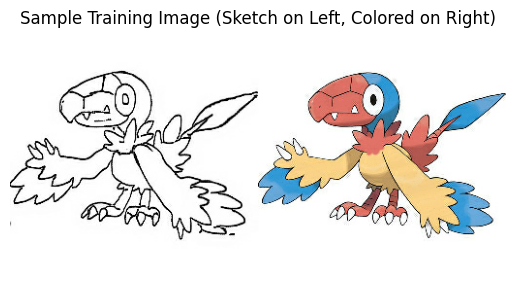

In [ ]:
# Inspect the structure of the dataset
print("Directory contents:", list(path.iterdir()))

train_path = main_dir / 'train'
test_path = main_dir / 'test'

#checking
if train_path.exists() and test_path.exists():
    print(f"Number of training images: {len(list(train_path.iterdir()))}")
    print(f"Number of test images: {len(list(test_path.iterdir()))}")

    # Load and display a sample image from the training directory
    sample_train_image_path = next(train_path.iterdir())
    sample_image = tf.io.read_file(str(sample_train_image_path))
    sample_image = tf.io.decode_jpeg(sample_image)

    # Print the shape of the sample image
    print(f"Sample training image shape: {sample_image.shape}")

    # Display the sample training image
    plt.figure()
    plt.imshow(sample_image)
    plt.axis('off')
    plt.title("Sample Training Image (Sketch on Left, Colored on Right)")
    plt.show()
else:
    print("Directories 'train' or 'test' not found. Please verify the dataset structure.")


Seperating Dataset into Real (coloured) and Input(B/W) images

In [ ]:
def load(image_file):

    # Read and decode the image file
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split the image into two halves
    w = tf.shape(image)[1]  # Get the width of the image
    w = w // 2  # Half the width
    input_image = image[:, :w, :]  # Right half for the input image
    real_image = image[:, w:, :]  # Left half for the real image

    # Convert images to float32
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


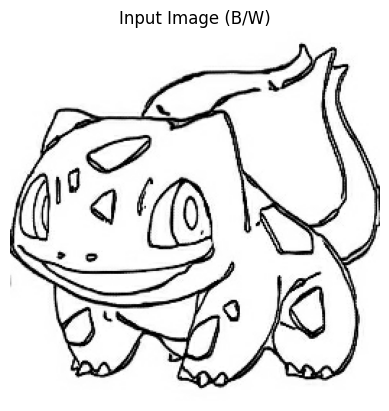

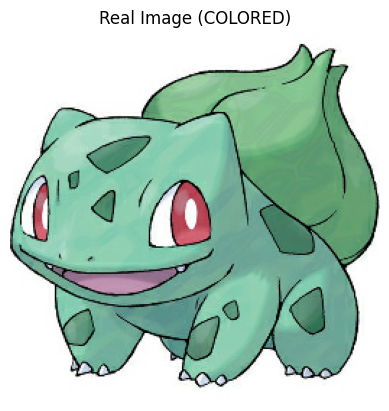

In [ ]:

# Load and split a sample image
sample_image_path = train_path / '0.jpg'  # Replace '0.jpg' with an actual file name
if sample_image_path.exists():
    input_image, real_image = load(str(sample_image_path))

    # Normalize for display and visualize
    plt.figure()
    plt.imshow(input_image / 255.0)
    plt.title("Input Image (B/W)")
    plt.axis("off")

    plt.figure()
    plt.imshow(real_image / 255.0)
    plt.title("Real Image (COLORED)")
    plt.axis("off")

    plt.show()
else:
    print(f"Sample image not found at {sample_image_path}")


In [ ]:
def process_dataset(directory):

    directory = pathlib.Path(directory)
    image_files = list(directory.glob("*.png"))  # Adjust extension if needed

    for image_file in image_files[:5]:  # Limit to 5 images for demonstration
        input_image, real_image = load(str(image_file))
        plt.figure()
        plt.imshow(input_image / 255.0)
        plt.title("Input Image")
        plt.axis("off")

        plt.figure()
        plt.imshow(real_image / 255.0)
        plt.title("Real Image")
        plt.axis("off")
        plt.show()

# Process the training dataset
process_dataset(train_path)


Taken references from Pix-2-pix paper





In [ ]:
# The training set consist of 820 images
BUFFER_SIZE = 830
#In the original pix2pix paper, training with a batch size of 1 provided better results for the U-Net generator.
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

Resizing the images to be 256x256x3

Random cropping, Normalization ,and random jitering done to augment the data



In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)#[2, height, width, channels].
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
# List all .jpg files in the train directory
train_files = list(train_path.glob("*.jpg"))
# Load the image
sample_image_path = str(train_files[0])
inp, re = load(sample_image_path)

In [ ]:
# Inspect the base directory to get the correct structure
print(f"Inspecting directory: {train_path}")

for item in train_path.iterdir():
    print(item)

Inspecting directory: /root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/577.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/731.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/685.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/533.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/233.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/582.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/365.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pokemon/versions/1/pokemon_pix2pix_dataset/train/803.jpg
/root/.cache/kagglehub/datasets/norod78/sketch2pok

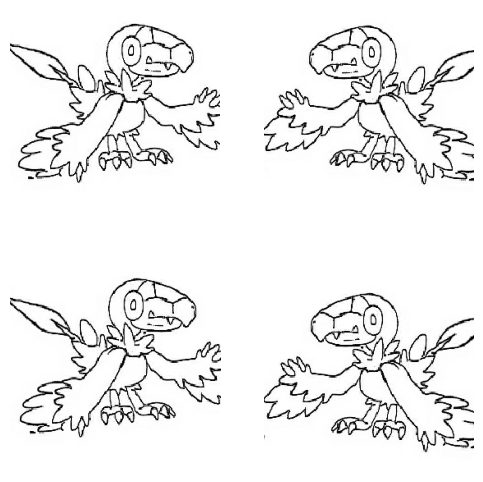

In [ ]:
# Assuming `inp` and `re` are the original input and real images
# Normalize inp and re to [0, 255] for visualization
inp, re = normalize(inp, re)

plt.figure(figsize=(6, 6))
for i in range(4):
    # Apply random jittering
    rj_inp, rj_re = random_jitter(inp, re)

    # Normalize images back to [0, 1] for visualization
    rj_inp_vis = (rj_inp + 1) / 2
    rj_re_vis = (rj_re + 1) / 2

    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp_vis.numpy())  # Display the input image
    plt.axis("off")

plt.show()


Loading Train and Test data after augmentation


In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

Build an input pipeline with tf.data

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(train_path / '*.jpg'))  # Adjusted to .png format
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)#runs parallel calls for loading and processing
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)# Batch size = 1; one image at a time

In [ ]:
for inp, re in train_dataset.take(1):
    print(f"Input image shape: {inp.shape}")
    print(f"Real image shape: {re.shape}")

Input image shape: (1, 256, 256, 3)
Real image shape: (1, 256, 256, 3)


In [ ]:
# Function to load and preprocess validation images (without augmentation)
def load_image_test(image_path):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Adjusted to .png format

    # Resize the image and normalize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    input_image, real_image = normalize(image, image)  # Only normalize, no cropping

    return input_image, real_image

# List files in the validation directory
test_dataset = tf.data.Dataset.list_files(str(test_path/ '*.jpg'))  # Adjusted to .png format

# Apply map to load and preprocess the validation images
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Example: Print the dataset shape and first batch
for inp, re in test_dataset.take(1):
    print(f"test input image shape: {inp.shape}")
    print(f"test real image shape: {re.shape}")


test input image shape: (1, 256, 256, 3)
test real image shape: (1, 256, 256, 3)


In [ ]:
inp= tf.squeeze(inp, axis=0)
re =tf.squeeze(re ,axis=0)

In [ ]:
# Ensure inp has the shape (256, 256, 3)
print("Original inp shape:", inp.shape)

Original inp shape: (256, 256, 3)


Generator

A _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](../images/segmentation.ipynb) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result




In [ ]:
print(inp.shape)  # It should print (256, 256, 3)


(256, 256, 3)


In [ ]:
# Ensure inp has a batch dimension
inp = tf.expand_dims(inp, axis=0)  # Add batch dimension, shape becomes (1, 256, 256, 3)

# Define and use the downsample model
down_model = downsample(3, 4)  # 3 output channels, kernel size 4
down_result = down_model(inp)  # Pass the batched input
print("Final output shape:", down_result.shape)


Final output shape: (1, 128, 128, 3)


Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Define the generator with the downsampler and the upsampler:

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


Visualize the generator model architecture:

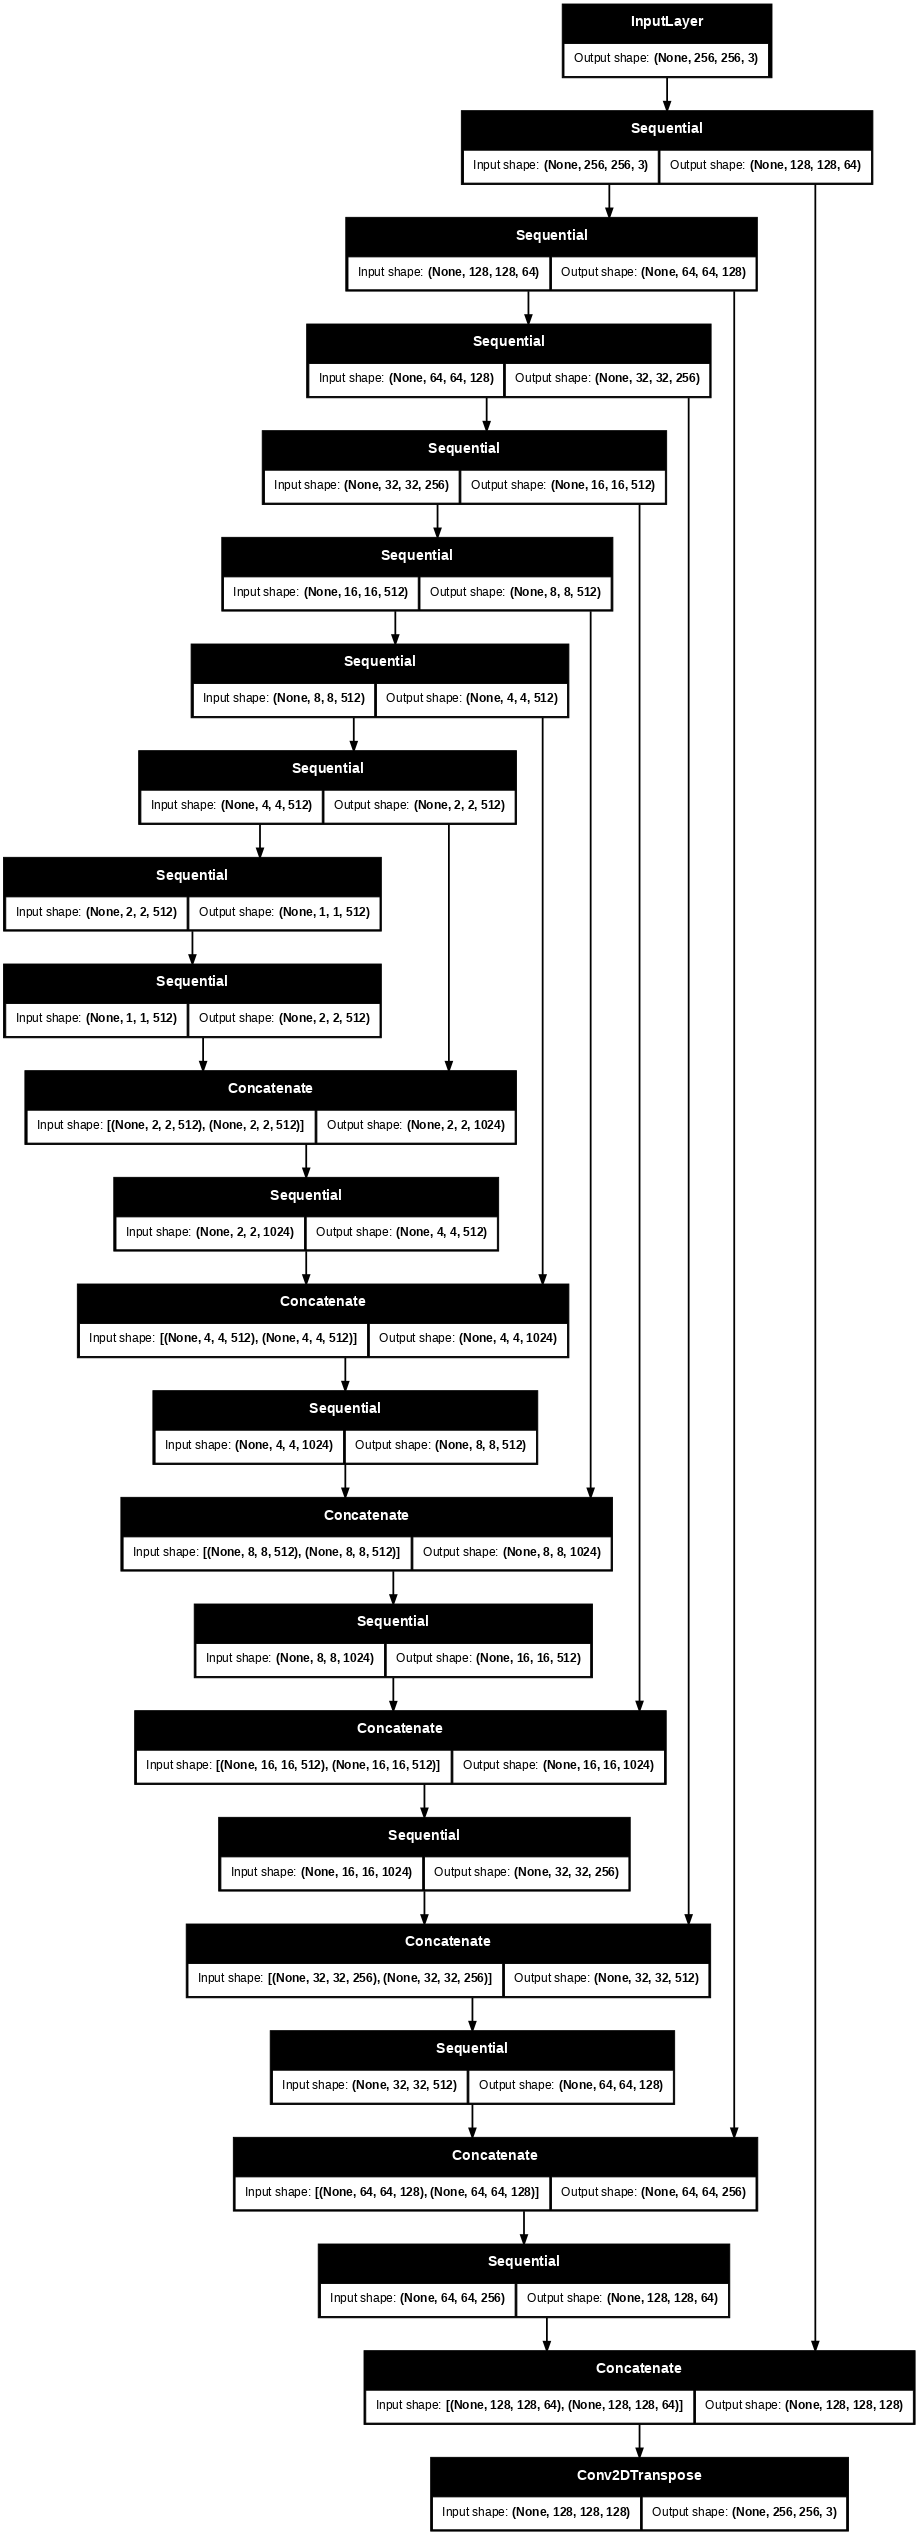

In [ ]:
generator = Generator()

# Visualize the model architecture (optional)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

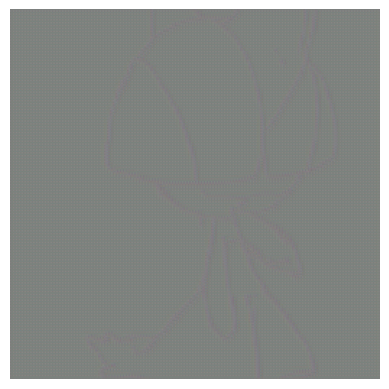

In [ ]:
# Generate output using the generator
gen_output = generator(inp, training=False)

# Rescale and plot the image (if needed)
gen_output_rescaled = (gen_output + 1) / 2  # This is necessary if you're using 'tanh'

# Plot the result
plt.imshow(gen_output_rescaled[0, ...])  # Display the first image in the batch
plt.axis('off')  # Hide axis for better visual quality
plt.show()


In [ ]:
print("Generator output range:", gen_output.numpy().min(), gen_output.numpy().max())


Generator output range: -0.12582752 0.1064133


Generator loss

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Discriminator

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

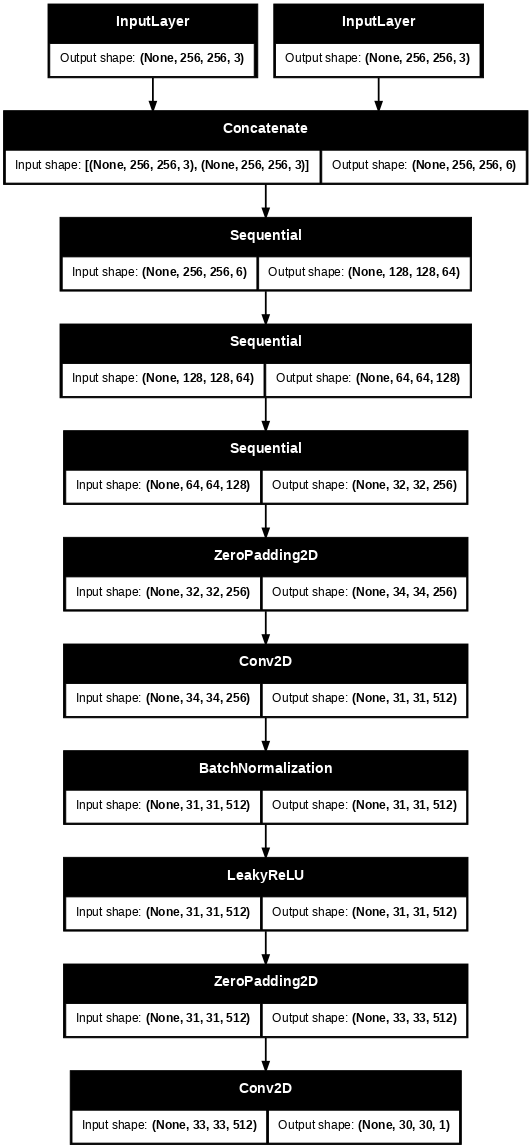

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

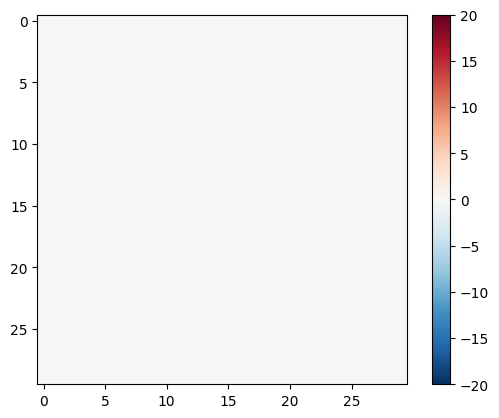

In [ ]:
disc_out = discriminator([inp, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Define the optimizers and a checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

A function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

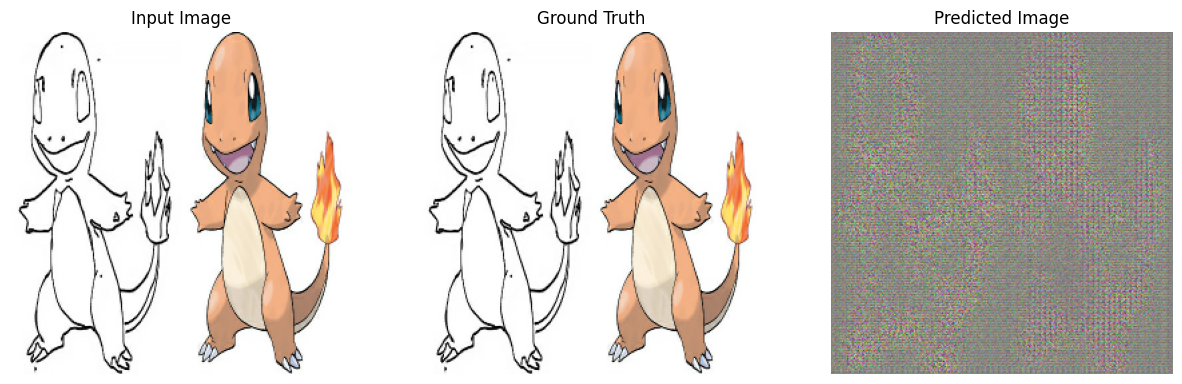

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [ ]:
from scipy.linalg import sqrtm
import numpy as np
from tensorflow.keras.applications import inception_v3

# 1. Function to Calculate FID Score
def calculate_fid(real_images, generated_images):
    """
    Calculate Fréchet Inception Distance (FID) between real and generated images.

    Args:
        real_images: A batch of real images, shape (batch_size, height, width, channels).
        generated_images: A batch of generated images, shape (batch_size, height, width, channels).

    Returns:
        fid_score: The calculated FID score.
    """
    # Load the InceptionV3 model for feature extraction
    inception_model = inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize images to (299, 299, 3) as required by InceptionV3
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Normalize images to range [-1, 1]
    real_images_norm = (real_images_resized / 127.5) - 1.0
    generated_images_norm = (generated_images_resized / 127.5) - 1.0

    # Extract features using InceptionV3
    real_features = inception_model(real_images_norm)
    generated_features = inception_model(generated_images_norm)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Compute the FID score
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean = sqrtm(sigma_real @ sigma_gen)

    # Handle imaginary values from sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid_score




In [ ]:
def track_loss(epoch, gen_gan_loss, gen_l1_loss, disc_loss):
    # Convert tensors to NumPy scalars for compatibility
    gen_gan_loss = gen_gan_loss.numpy() if hasattr(gen_gan_loss, 'numpy') else gen_gan_loss
    gen_l1_loss = gen_l1_loss.numpy() if hasattr(gen_l1_loss, 'numpy') else gen_l1_loss
    disc_loss = disc_loss.numpy() if hasattr(disc_loss, 'numpy') else disc_loss

    print(f"Step {epoch}:")
    print(f" - Generator Adversarial Loss: {gen_gan_loss:.4f}")
    print(f" - Generator L1 Loss: {gen_l1_loss:.4f}")
    print(f" - Discriminator Loss: {disc_loss:.4f}")
    print("=" * 50)


In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_gan_loss, gen_l1_loss, disc_loss


The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target)
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)

        # Log loss metrics
        if (step + 1) % 1000 == 0:
            track_loss(step, gen_gan_loss, gen_l1_loss, disc_loss)

        # Save model checkpoints every 3000 steps
        if (step + 1) % 1000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


Finally, run the training loop:

Time taken for 1000 steps: 2961.43 sec



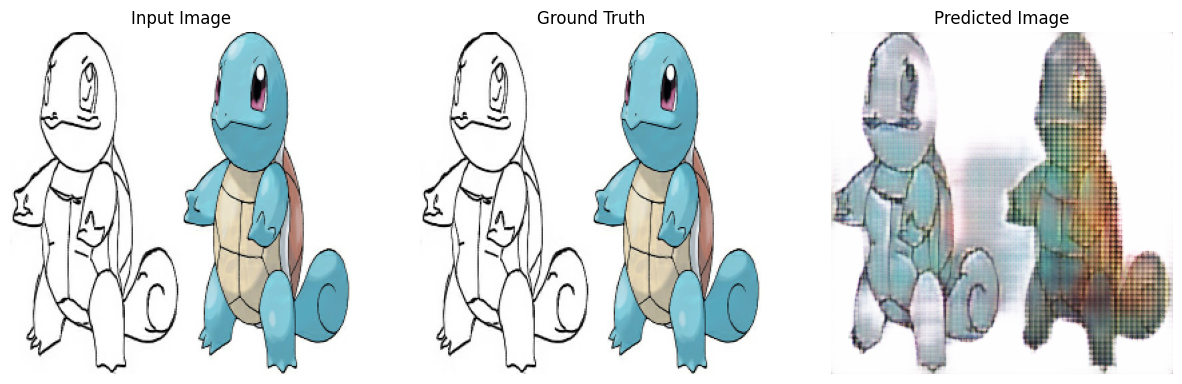

Step: 1k
....................................................................................................Step 1999:
 - Generator Adversarial Loss: 3.9013
 - Generator L1 Loss: 0.2416
 - Discriminator Loss: 1.3101


In [ ]:
fit(train_dataset, test_dataset, steps=2000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

checkpoint  ckpt-1.data-00000-of-00001	ckpt-1.index  ckpt-2.data-00000-of-00001  ckpt-2.index


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

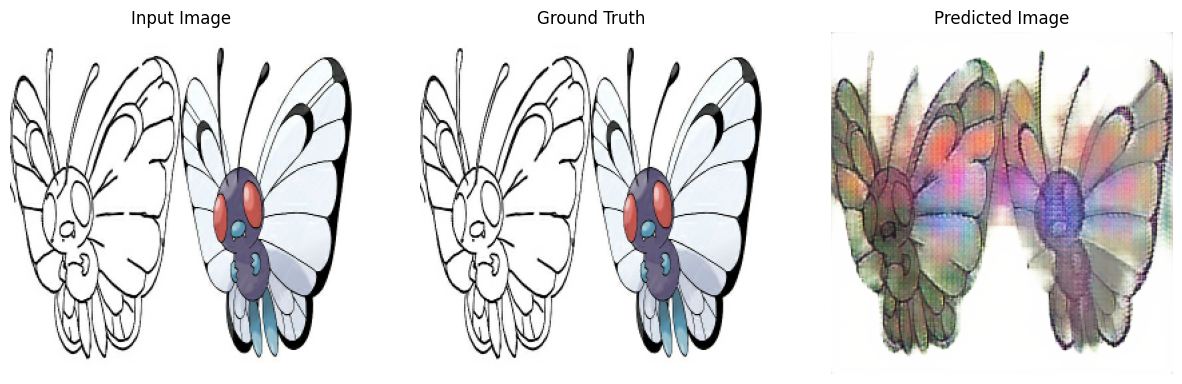

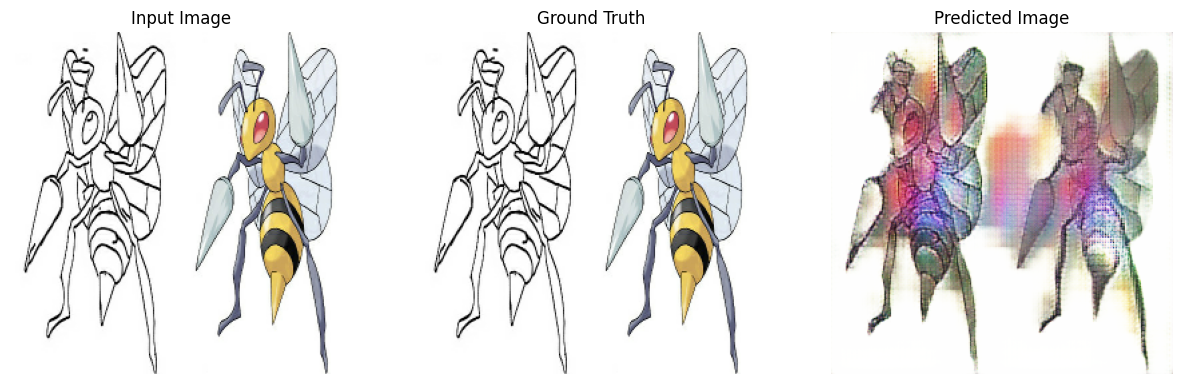

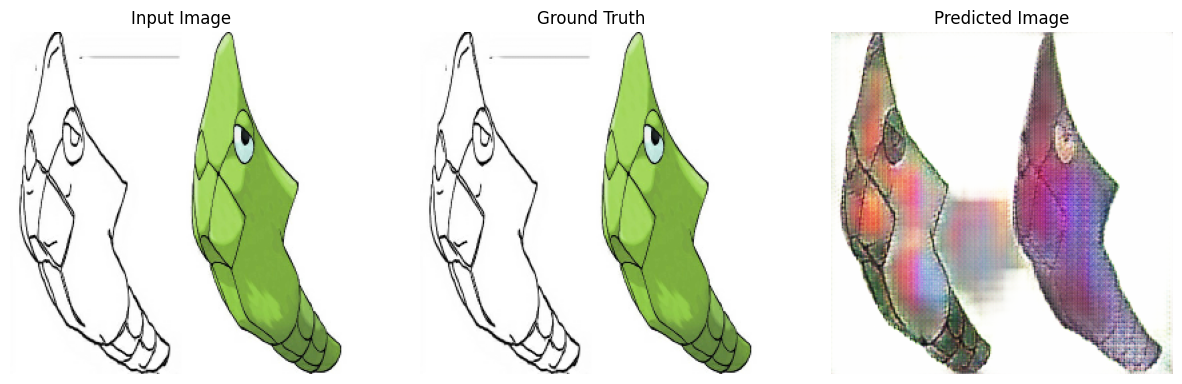

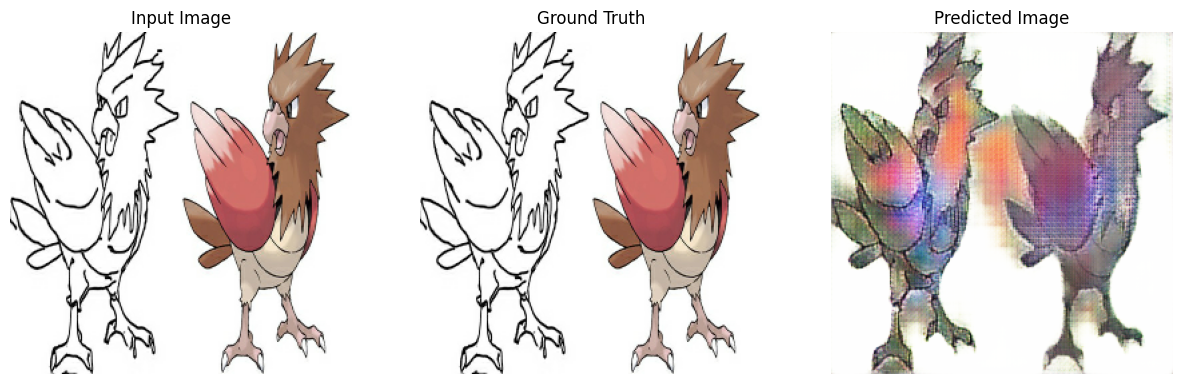

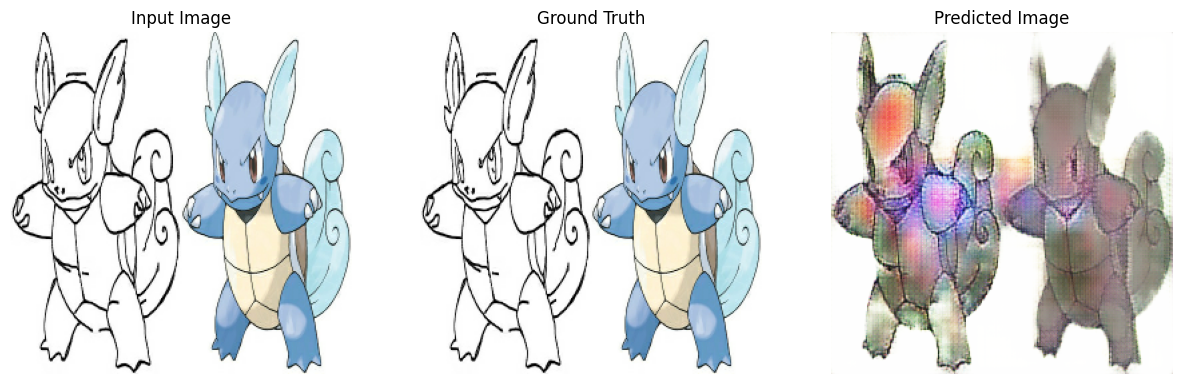

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3
from scipy.linalg import sqrtm

# Function to calculate the Fréchet Inception Distance (FID)
def calculate_fid(real_images, generated_images):
    """
    Calculate the Fréchet Inception Distance (FID) between real and generated images.

    Args:
        real_images (np.ndarray): Array of real images (N, H, W, C) normalized to [0, 1].
        generated_images (np.ndarray): Array of generated images (N, H, W, C) normalized to [0, 1].

    Returns:
        float: FID score.
    """
    # Load the InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Resize and preprocess images for InceptionV3
    def preprocess_images(images):
        images = tf.image.resize(images, (299, 299))
        return tf.keras.applications.inception_v3.preprocess_input(images)

    # Preprocess both sets of images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Extract features using the InceptionV3 model
    real_features = inception_model.predict(real_images)
    gen_features = inception_model.predict(generated_images)

    # Calculate the mean and covariance for both sets
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(gen_features, axis=0), np.cov(gen_features, rowvar=False)

    # Compute the FID score
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Function to calculate L1 Loss
def calculate_l1_loss(real_images, generated_images):
    """
    Calculate the L1 loss between real and generated images.

    Args:
        real_images (tf.Tensor): Tensor of real images.
        generated_images (tf.Tensor): Tensor of generated images.

    Returns:
        float: L1 loss.
    """
    return tf.reduce_mean(tf.abs(real_images - generated_images)).numpy()

# Example usage (replace with actual data)
real_images = np.random.rand(10, 256, 256, 3)  # Placeholder for real images
generated_images = np.random.rand(10, 256, 256, 3)  # Placeholder for generated images

# Calculate FID and L1 Loss
fid_score = calculate_fid(real_images, generated_images)
l1_loss = calculate_l1_loss(real_images, generated_images)

# Print the results
print(f"FID Score: {fid_score:.2f}")
print(f"L1 Loss: {l1_loss:.4f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
FID Score: 0.07
L1 Loss: 0.3331


There’s still room for improvement, which I’ll be working on soon. Once that’s done, I’ll be hosting it on a webpage as well. I’ll provide an update soon!